<a href="https://colab.research.google.com/github/Crltt/GCA-ROM/blob/main/notebook/3_maxwell_THy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [18]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [19]:
# Clone and import gca-rom
!git clone https://github.com/Crltt/GCA-ROM.git
import sys
sys.path.append('GCA-ROM')
from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


fatal: destination path 'GCA-ROM' already exists and is not an empty directory.


In [20]:
import numpy as np
from itertools import product

# Define PDE problem
For the description of the model and generation of the dataset look at: Hesthaven, Jan & Warburton, Tim. (2007). Nodal Discontinuous Galerkin Methods: Algorithms, Analysis, and Applications (https://github.com/tcew/nodal-dg.git)

In [21]:
problem_name, variable, mu_space, n_param = pde.problem(3)
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Parameters: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)
HyperParams = network.HyperParams(argv)


Problem:  maxwell
Variable:  THy
Parameters:  1


# Initialize device and set reproducibility

In [22]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cpu


# Load dataset

In [23]:
dataset_dir = 'GCA-ROM/dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

Number of nodes processed:  1220
Number of graphs processed:  326
Length of train dataset:  97
Length of test dataset:  229


# Define the architecture

In [24]:
model = network.Net(HyperParams)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [25]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt', map_location=torch.device('cpu')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Training network


100%|██████████| 5000/5000 [1:51:36<00:00,  1.34s/it, Loss(training)=0.00157, Loss(validation)=2.63]


Loading best network for epoch:  4312


# Evaluate the model

In [26]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 326/326 [00:02<00:00, 143.80it/s]


# Plot the results

100%|██████████| 229/229 [00:01<00:00, 148.14it/s]


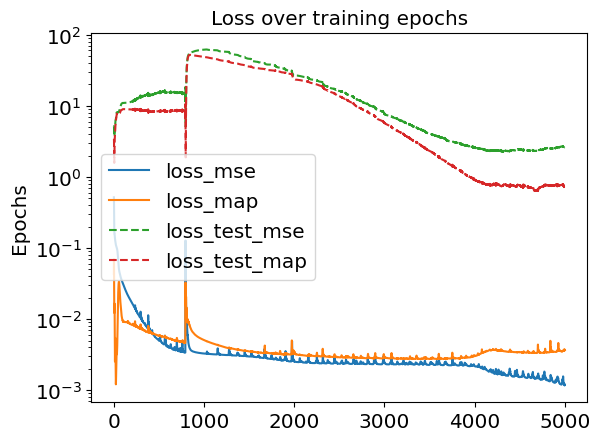

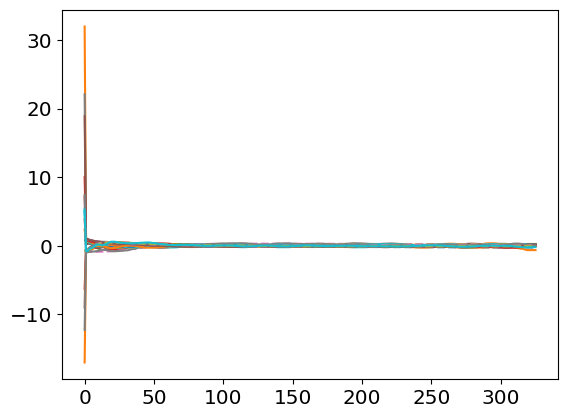

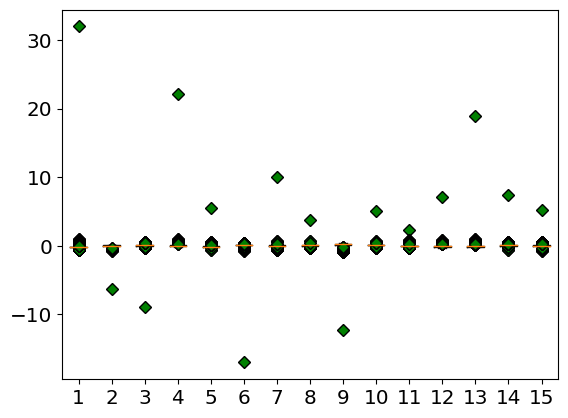

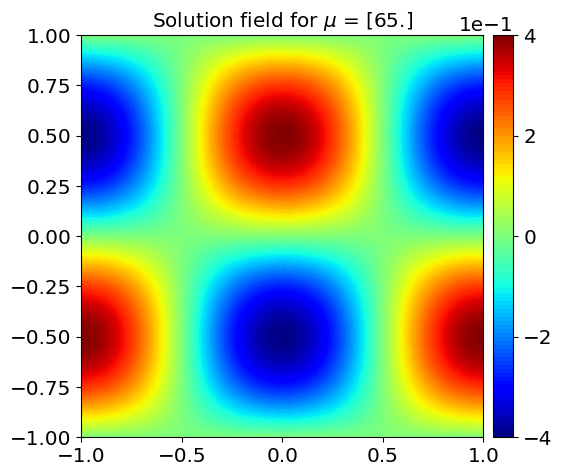

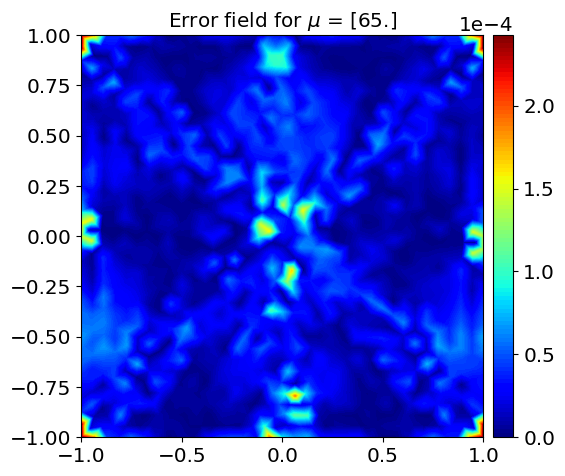

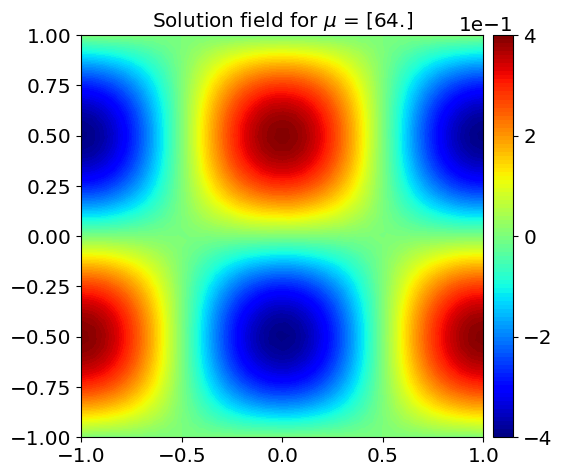

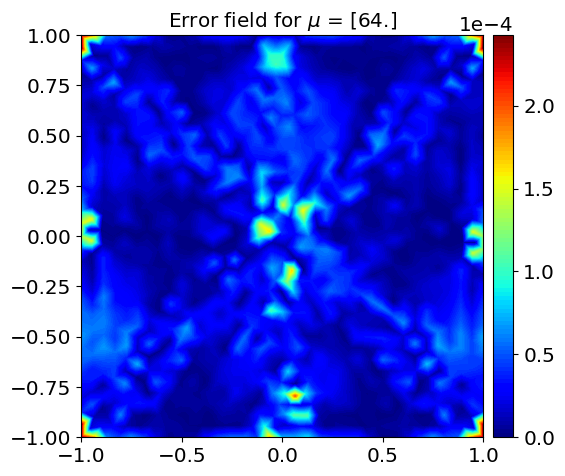

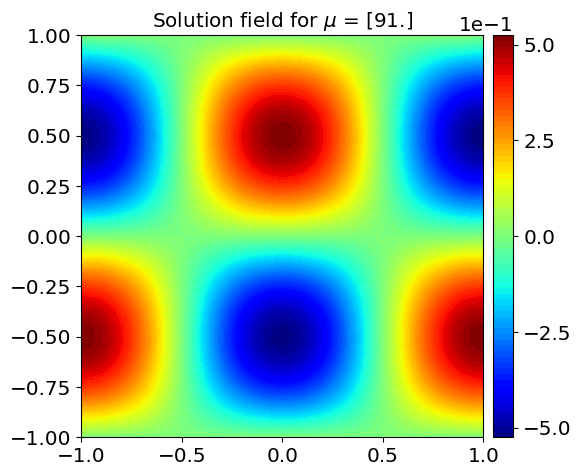

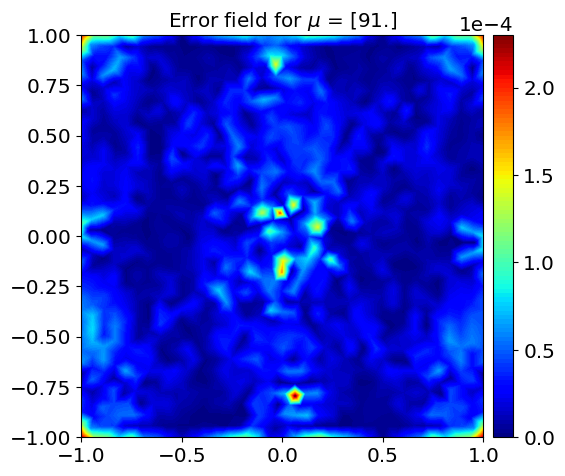

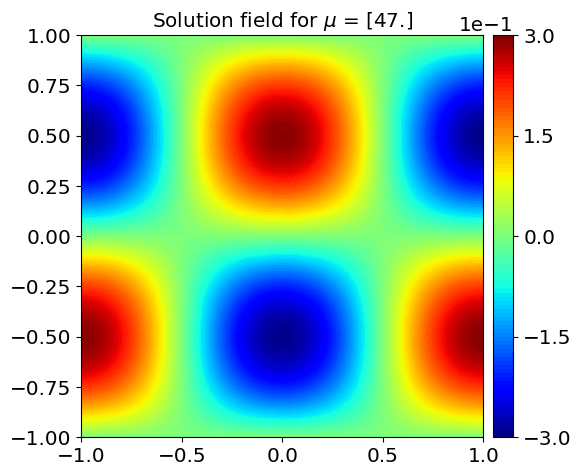

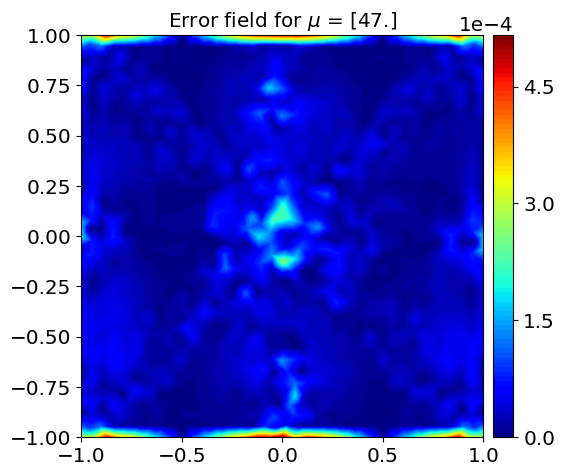

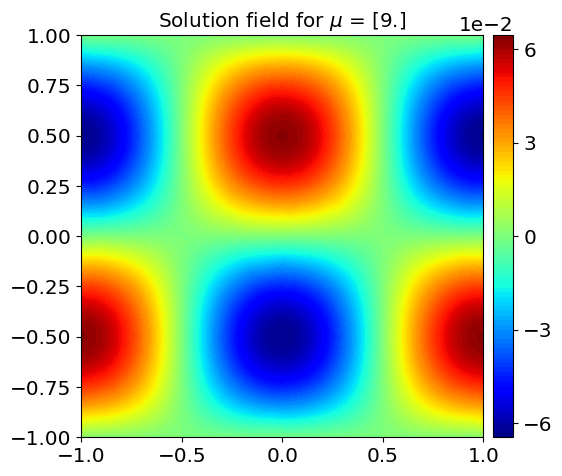

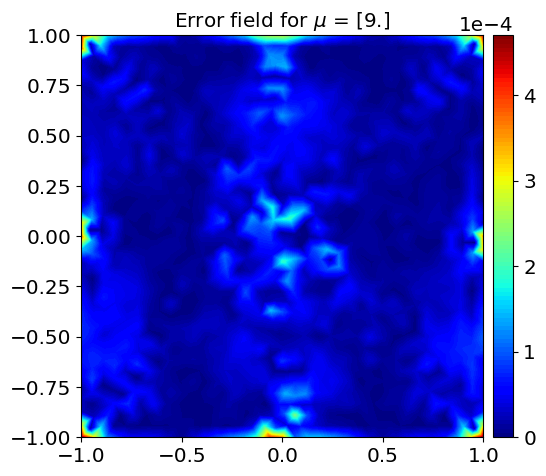

In [27]:
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)
#plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)



N = 5
#snapshots = np.arange(params.shape[0]).tolist()
snapshots = np.arange(100).tolist()
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
    plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

# Print the errors on the testing set

In [28]:
error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)



Maximum absolute error for field GCA-ROM =  34.909906583041135
Mean absolute error for field GCA-ROM =  0.16433646200586555
Minimum absolute error for field GCA-ROM =  0.000560434547770835

Maximum relative error for field GCA-ROM =  1.078517925681121e+17
Mean relative error for field GCA-ROM =  470968526498306.1
Minimum relative error for field GCA-ROM =  0.0011034069766584253


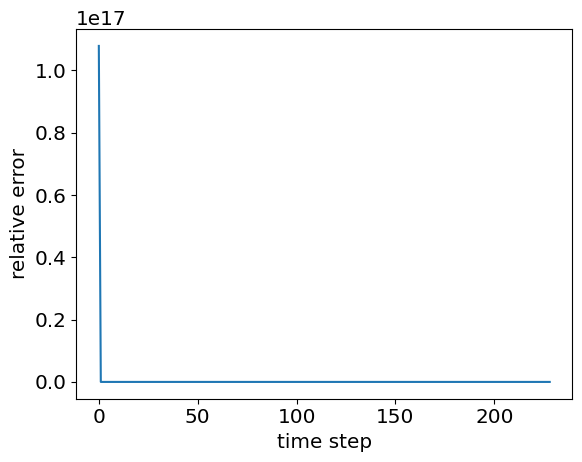

In [29]:
# when just one parameter
import matplotlib.pyplot as plt
plt.plot(np.array(error_abs)/np.array(norm))
plt.xlabel('time step')
plt.ylabel('relative error')
plt.show()

In [30]:
import shutil
shutil.make_archive('maxwell', 'zip', 'maxwell')

'/content/maxwell.zip'

In [31]:
from google.colab import files
files.download('maxwell.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

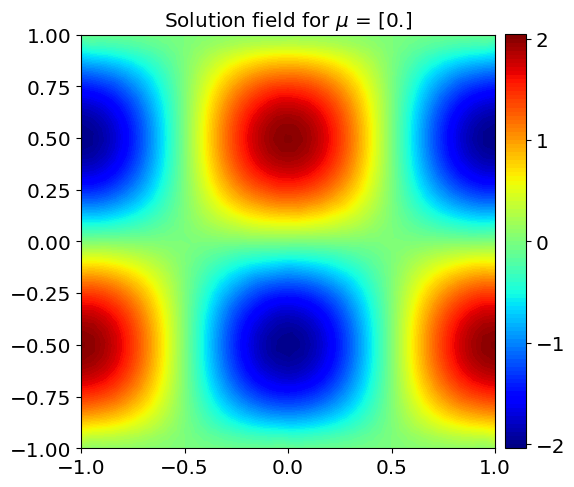

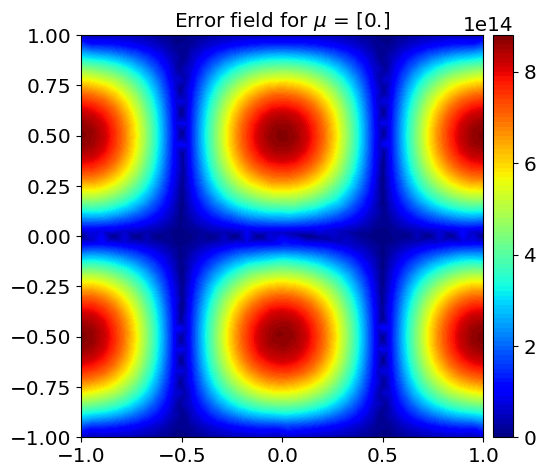

In [32]:
    plotting.plot_fields(0, results, scaler_all, HyperParams, dataset, xyz, params)
    plotting.plot_error_fields(0, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)